In [1]:
import pandas as pd

# Load raw data
df = pd.read_csv("../data/raw/lendingclub_loans.csv", low_memory=False)

print("Initial shape:", df.shape)
print("\nLoan status distribution:")
print(df['loan_status'].value_counts())


Initial shape: (2260668, 145)

Loan status distribution:
loan_status
Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: count, dtype: int64


In [2]:
# Define default indicator
default_status = ['Charged Off', 'Default']
non_default_status = ['Fully Paid']

df = df[df['loan_status'].isin(default_status + non_default_status)].copy()

df['default'] = df['loan_status'].apply(
    lambda x: 1 if x in default_status else 0
)

print("After filtering shape:", df.shape)
print("\nDefault rate:")
print(df['default'].value_counts(normalize=True))


After filtering shape: (1303638, 146)

Default rate:
default
0    0.799265
1    0.200735
Name: proportion, dtype: float64


In [3]:
# Parse issue date
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')

print(df['issue_d'].min(), df['issue_d'].max())


2007-06-01 00:00:00 2018-12-01 00:00:00


In [4]:
df = df.sort_values('issue_d').reset_index(drop=True)

print("Earliest date:", df['issue_d'].iloc[0])
print("Latest date:", df['issue_d'].iloc[-1])


Earliest date: 2007-06-01 00:00:00
Latest date: 2018-12-01 00:00:00


In [5]:
df = df[
    (df['issue_d'] >= '2008-01-01') &
    (df['issue_d'] <= '2018-12-31')
].copy()

print("After date filtering shape:", df.shape)
print("New date range:")
print(df['issue_d'].min(), df['issue_d'].max())


After date filtering shape: (1303387, 146)
New date range:
2008-01-01 00:00:00 2018-12-01 00:00:00


In [6]:
# Inspect FICO-related columns
[col for col in df.columns if 'fico' in col.lower()]


[]

In [7]:
'sub_grade' in df.columns


True

In [8]:
features = [
    'loan_amnt',
    'int_rate',
    'annual_inc',
    'dti',
    'open_acc',
    'revol_util',
    'delinq_2yrs',
    'grade',
    'sub_grade',
    'purpose'
]

df_model = df[['issue_d', 'default'] + features].copy()

print("Modeling dataset shape:", df_model.shape)
df_model.head()


Modeling dataset shape: (1303387, 12)


,issue_d,default,loan_amnt,int_rate,annual_inc,dti,open_acc,revol_util,delinq_2yrs,grade,sub_grade,purpose
251,2008-01-01,1,9600,9.20,62000.0,13.12,15.0,40.3,0.0,B,B1,credit_card
252,2008-01-01,0,22000,12.67,90000.0,13.04,14.0,30.8,1.0,D,D2,credit_card
253,2008-01-01,1,10000,13.30,120000.0,6.31,11.0,89.3,0.0,D,D4,small_business
254,2008-01-01,0,18500,9.51,31000.0,16.49,11.0,37.9,0.0,B,B2,debt_consolidation
255,2008-01-01,0,6000,8.38,40500.0,12.50,6.0,42.4,0.0,A,A5,debt_consolidation


In [9]:
# Missing value proportions
missing = df_model.isnull().mean().sort_values(ascending=False)
missing


revol_util     0.000621
dti            0.000239
issue_d        0.000000
default        0.000000
loan_amnt      0.000000
int_rate       0.000000
annual_inc     0.000000
open_acc       0.000000
delinq_2yrs    0.000000
grade          0.000000
sub_grade      0.000000
purpose        0.000000
dtype: float64

In [10]:
# Separate numerical and categorical columns
num_cols = df_model.select_dtypes(include=['number']).columns
cat_cols = df_model.select_dtypes(include=['object']).columns

# Median imputation for numerical variables
for col in num_cols:
    df_model[col] = df_model[col].fillna(df_model[col].median())

# 'Missing' category for categorical variables
for col in cat_cols:
    df_model[col] = df_model[col].fillna('Missing')

# Verify no missing values remain
df_model.isnull().sum().sort_values(ascending=False)


/var/folders/vp/7cs7t_953kscjs623sfz7t2r0000gn/T/ipykernel_33306/285179830.py:3: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = df_model.select_dtypes(include=['object']).columns


issue_d        0
default        0
loan_amnt      0
int_rate       0
annual_inc     0
dti            0
open_acc       0
revol_util     0
delinq_2yrs    0
grade          0
sub_grade      0
purpose        0
dtype: int64

In [11]:
# One-hot encode categorical variables
df_encoded = pd.get_dummies(
    df_model,
    columns=['grade', 'sub_grade', 'purpose'],
    drop_first=True
)

print("Encoded dataset shape:", df_encoded.shape)
df_encoded.head()


Encoded dataset shape: (1303387, 62)


,issue_d,default,loan_amnt,int_rate,annual_inc,dti,open_acc,revol_util,delinq_2yrs,grade_B,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
251,2008-01-01,1,9600,9.20,62000.0,13.12,15.0,40.3,0.0,True,...,False,False,False,False,False,False,False,False,False,False
252,2008-01-01,0,22000,12.67,90000.0,13.04,14.0,30.8,1.0,False,...,False,False,False,False,False,False,False,False,False,False
253,2008-01-01,1,10000,13.30,120000.0,6.31,11.0,89.3,0.0,False,...,False,False,False,False,False,False,False,True,False,False
254,2008-01-01,0,18500,9.51,31000.0,16.49,11.0,37.9,0.0,True,...,False,False,False,False,False,False,False,False,False,False
255,2008-01-01,0,6000,8.38,40500.0,12.50,6.0,42.4,0.0,False,...,False,False,False,False,False,False,False,False,False,False


In [12]:
# Time-based train-test split
train = df_encoded[df_encoded['issue_d'] < '2016-01-01'].copy()
test = df_encoded[df_encoded['issue_d'] >= '2016-01-01'].copy()

print("Train shape:", train.shape)
print("Test shape:", test.shape)

print("\nTrain default rate:")
print(train['default'].mean())

print("\nTest default rate:")
print(test['default'].mean())


Train shape: (822575, 62)
Test shape: (480812, 62)

Train default rate:
0.18432604929641674

Test default rate:
0.22881916424714857


In [13]:
from sklearn.linear_model import LogisticRegression

# Separate features and target
X_train = train.drop(columns=['default', 'issue_d'])
y_train = train['default']

X_test = test.drop(columns=['default', 'issue_d'])
y_test = test['default']

print(X_train.shape, X_test.shape)


(822575, 60) (480812, 60)


In [14]:
# Baseline logistic regression (MLE approximation)
logit = LogisticRegression(
    max_iter=1000,
    solver='lbfgs'
)

logit.fit(X_train, y_train)


/Users/nikhilsudan/credit-risk-economic-regimes/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [15]:
# Predicted probabilities
train_pd = logit.predict_proba(X_train)[:, 1]
test_pd = logit.predict_proba(X_test)[:, 1]

print("Train PD mean:", train_pd.mean())
print("Test PD mean:", test_pd.mean())


Train PD mean: 0.18206337575778292
Test PD mean: 0.1853934707601694


In [16]:
from sklearn.metrics import roc_auc_score, brier_score_loss
import numpy as np

# ROC-AUC
train_auc = roc_auc_score(y_train, train_pd)
test_auc = roc_auc_score(y_test, test_pd)

# Brier score
train_brier = brier_score_loss(y_train, train_pd)
test_brier = brier_score_loss(y_test, test_pd)

# KS statistic
def ks_statistic(y_true, y_score):
    data = np.vstack([y_true, y_score]).T
    data = data[data[:, 1].argsort()]
    cum_pos = np.cumsum(data[:, 0]) / data[:, 0].sum()
    cum_neg = np.cumsum(1 - data[:, 0]) / (1 - data[:, 0]).sum()
    return np.max(np.abs(cum_pos - cum_neg))

train_ks = ks_statistic(y_train.values, train_pd)
test_ks = ks_statistic(y_test.values, test_pd)

print("TRAIN METRICS")
print("AUC:", train_auc)
print("KS :", train_ks)
print("Brier:", train_brier)

print("\nTEST METRICS")
print("AUC:", test_auc)
print("KS :", test_ks)
print("Brier:", test_brier)


TRAIN METRICS
AUC: 0.6906525409473321
KS : 0.28560026556475204
Brier: 0.13990624635114243

TEST METRICS
AUC: 0.6827131276449506
KS : 0.27193831430464527
Brier: 0.16636677451954485


In [17]:
from fredapi import Fred
import pandas as pd

fred = Fred()

unrate = fred.get_series('UNRATE')
cpi = fred.get_series('CPIAUCSL')
fedfunds = fred.get_series('FEDFUNDS')

macro = pd.DataFrame({
    'unrate': unrate,
    'cpi': cpi,
    'fedfunds': fedfunds
})

macro.index = pd.to_datetime(macro.index)
macro = macro.resample('MS').mean()

macro.head()


,unrate,cpi,fedfunds
1947-01-01,NaN,21.48,NaN
1947-02-01,NaN,21.62,NaN
1947-03-01,NaN,22.00,NaN
1947-04-01,NaN,22.00,NaN
1947-05-01,NaN,21.95,NaN


In [18]:
macro['inflation_yoy'] = macro['cpi'].pct_change(12) * 100
macro = macro.dropna()

macro[['unrate', 'inflation_yoy', 'fedfunds']].head()


,unrate,inflation_yoy,fedfunds
1954-07-01,5.8,0.261292,0.80
1954-08-01,6.0,0.000000,1.22
1954-09-01,6.1,-0.297508,1.07
1954-10-01,5.7,-0.853432,0.85
1954-11-01,5.3,-0.260708,0.83


In [19]:
unrate_median = macro['unrate'].median()
macro['regime'] = (macro['unrate'] > unrate_median).astype(int)

macro['regime'].value_counts(normalize=True)


regime
0    0.533256
1    0.466744
Name: proportion, dtype: float64

In [21]:
# Create issue_month from issue_d
df_encoded['issue_month'] = (
    df_encoded['issue_d']
    .dt.to_period('M')
    .dt.to_timestamp()
)

# Merge regime info
df_regime = df_encoded.merge(
    macro[['regime']],
    left_on='issue_month',
    right_index=True,
    how='left'
)

# Check regime distribution
df_regime['regime'].value_counts(dropna=False)


regime
0    832384
1    471003
Name: count, dtype: int64

In [22]:
# Recreate time split with regime data
train_r = df_regime[df_regime['issue_d'] < '2016-01-01'].copy()
test_r  = df_regime[df_regime['issue_d'] >= '2016-01-01'].copy()

X_train_r = train_r.drop(columns=['default', 'issue_d', 'issue_month'])
y_train_r = train_r['default']

X_test_r = test_r.drop(columns=['default', 'issue_d', 'issue_month'])
y_test_r = test_r['default']

# Interaction terms (economic, not brute force)
interaction_vars = ['int_rate', 'dti', 'revol_util', 'loan_amnt']

for v in interaction_vars:
    X_train_r[f'{v}_x_regime'] = X_train_r[v] * X_train_r['regime']
    X_test_r[f'{v}_x_regime']  = X_test_r[v] * X_test_r['regime']

print(X_train_r.shape, X_test_r.shape)


(822575, 65) (480812, 65)


In [26]:
from sklearn.preprocessing import StandardScaler

scale_vars = ['int_rate', 'dti', 'revol_util', 'loan_amnt']

scaler = StandardScaler()

X_train_r[scale_vars] = scaler.fit_transform(X_train_r[scale_vars])
X_test_r[scale_vars]  = scaler.transform(X_test_r[scale_vars])


In [27]:
for v in scale_vars:
    X_train_r[f'{v}_x_regime'] = X_train_r[v] * X_train_r['regime']
    X_test_r[f'{v}_x_regime']  = X_test_r[v] * X_test_r['regime']


In [28]:
logit_regime_scaled = LogisticRegression(
    max_iter=2000,
    solver='lbfgs'
)

logit_regime_scaled.fit(X_train_r, y_train_r)


/Users/nikhilsudan/credit-risk-economic-regimes/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [29]:
train_pd_rs = logit_regime_scaled.predict_proba(X_train_r)[:, 1]
test_pd_rs  = logit_regime_scaled.predict_proba(X_test_r)[:, 1]

print("SCALED REGIME MODEL — TRAIN")
print("AUC:", roc_auc_score(y_train_r, train_pd_rs))
print("KS :", ks_statistic(y_train_r.values, train_pd_rs))
print("Brier:", brier_score_loss(y_train_r, train_pd_rs))

print("\nSCALED REGIME MODEL — TEST")
print("AUC:", roc_auc_score(y_test_r, test_pd_rs))
print("KS :", ks_statistic(y_test_r.values, test_pd_rs))
print("Brier:", brier_score_loss(y_test_r, test_pd_rs))


SCALED REGIME MODEL — TRAIN
AUC: 0.7013607494321451
KS : 0.29256354223849074
Brier: 0.13834818559033846

SCALED REGIME MODEL — TEST
AUC: 0.6880622202478124
KS : 0.2735565110955327
Brier: 0.16675747184917208


In [30]:
coef_df = pd.DataFrame({
    'feature': X_train_r.columns,
    'coef': logit_regime_scaled.coef_[0]
})

coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False)

coef_df.head(15)


,feature,coef,abs_coef
1,int_rate,0.672082,0.672082
13,sub_grade_A2,-0.343714,0.343714
14,sub_grade_A3,-0.327809,0.327809
60,regime,-0.323401,0.323401
55,purpose_other,-0.245033,0.245033
15,sub_grade_A4,-0.235242,0.235242
8,grade_C,0.190443,0.190443
9,grade_D,0.173162,0.173162
50,purpose_home_improvement,-0.171833,0.171833
12,grade_G,-0.149849,0.149849


In [31]:
coef_df['type'] = coef_df['feature'].apply(
    lambda x: 'interaction' if '_x_regime' in x else 'base'
)

coef_df.groupby('type')['abs_coef'].mean()


type
base           0.090202
interaction    0.050940
Name: abs_coef, dtype: float64

In [33]:
label_map = {
    'int_rate': 'Interest Rate (Base Effect)',
    'int_rate_x_regime': 'Interest Rate Sensitivity (Contraction Regime)',
    'dti': 'Debt-to-Income Ratio (Base Effect)',
    'dti_x_regime': 'Debt-to-Income Sensitivity (Contraction Regime)',
    'revol_util': 'Credit Utilization (Base Effect)',
    'revol_util_x_regime': 'Credit Utilization Sensitivity (Contraction Regime)'
}


In [34]:
plot_df = coef_df[coef_df['feature'].isin(label_map.keys())].copy()
plot_df['label'] = plot_df['feature'].map(label_map)


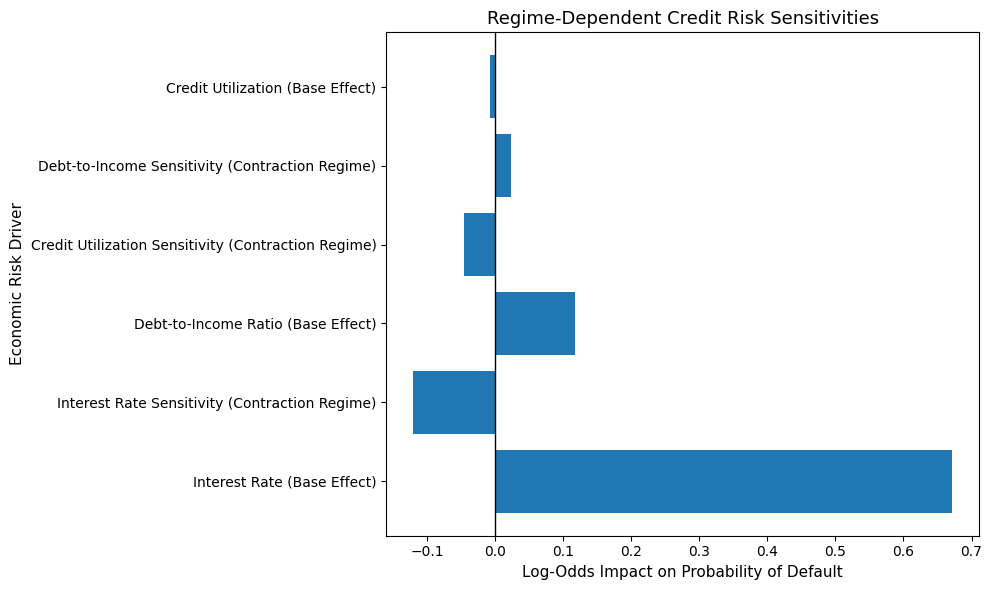

In [35]:
plt.figure(figsize=(10, 6))

plt.barh(plot_df['label'], plot_df['coef'])
plt.axvline(0, color='black', linewidth=1)

plt.title('Regime-Dependent Credit Risk Sensitivities', fontsize=13)
plt.xlabel('Log-Odds Impact on Probability of Default', fontsize=11)
plt.ylabel('Economic Risk Driver', fontsize=11)

plt.tight_layout()
plt.show()


In [36]:
# Build a representative borrower (median profile)
rep = X_train_r.median().to_frame().T

# Two regime states
rep_exp = rep.copy()
rep_con = rep.copy()

rep_exp['regime'] = 0
rep_con['regime'] = 1


In [37]:
import numpy as np

rate_grid = np.linspace(
    X_train_r['int_rate'].quantile(0.05),
    X_train_r['int_rate'].quantile(0.95),
    50
)

pd_exp, pd_con = [], []

for r in rate_grid:
    rep_exp_tmp = rep_exp.copy()
    rep_con_tmp = rep_con.copy()

    rep_exp_tmp['int_rate'] = r
    rep_con_tmp['int_rate'] = r

    rep_exp_tmp['int_rate_x_regime'] = r * rep_exp_tmp['regime']
    rep_con_tmp['int_rate_x_regime'] = r * rep_con_tmp['regime']

    pd_exp.append(
        logit_regime_scaled.predict_proba(rep_exp_tmp)[:, 1][0]
    )
    pd_con.append(
        logit_regime_scaled.predict_proba(rep_con_tmp)[:, 1][0]
    )


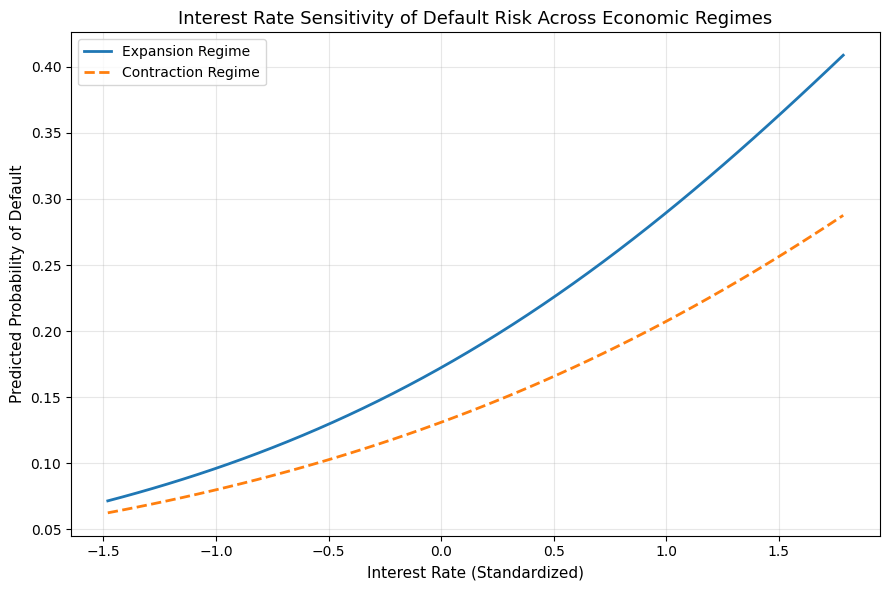

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))

plt.plot(rate_grid, pd_exp, label='Expansion Regime', linewidth=2)
plt.plot(rate_grid, pd_con, label='Contraction Regime', linewidth=2, linestyle='--')

plt.xlabel('Interest Rate (Standardized)', fontsize=11)
plt.ylabel('Predicted Probability of Default', fontsize=11)
plt.title('Interest Rate Sensitivity of Default Risk Across Economic Regimes', fontsize=13)

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [43]:
# Define grids (standardized space)
rate_grid = np.linspace(
    X_train_r['int_rate'].quantile(0.05),
    X_train_r['int_rate'].quantile(0.95),
    40
)

dti_grid = np.linspace(
    X_train_r['dti'].quantile(0.05),
    X_train_r['dti'].quantile(0.95),
    40
)

R, D = np.meshgrid(rate_grid, dti_grid)


In [44]:
def compute_pd_surface(regime_value):
    pd_surface = np.zeros_like(R)

    base = X_train_r.median().to_frame().T

    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            row = base.copy()
            row['int_rate'] = R[i, j]
            row['dti'] = D[i, j]
            row['regime'] = regime_value

            row['int_rate_x_regime'] = row['int_rate'] * row['regime']
            row['dti_x_regime'] = row['dti'] * row['regime']

            pd_surface[i, j] = logit_regime_scaled.predict_proba(row)[:, 1][0]

    return pd_surface


In [45]:
pd_expansion = compute_pd_surface(regime_value=0)
pd_contraction = compute_pd_surface(regime_value=1)


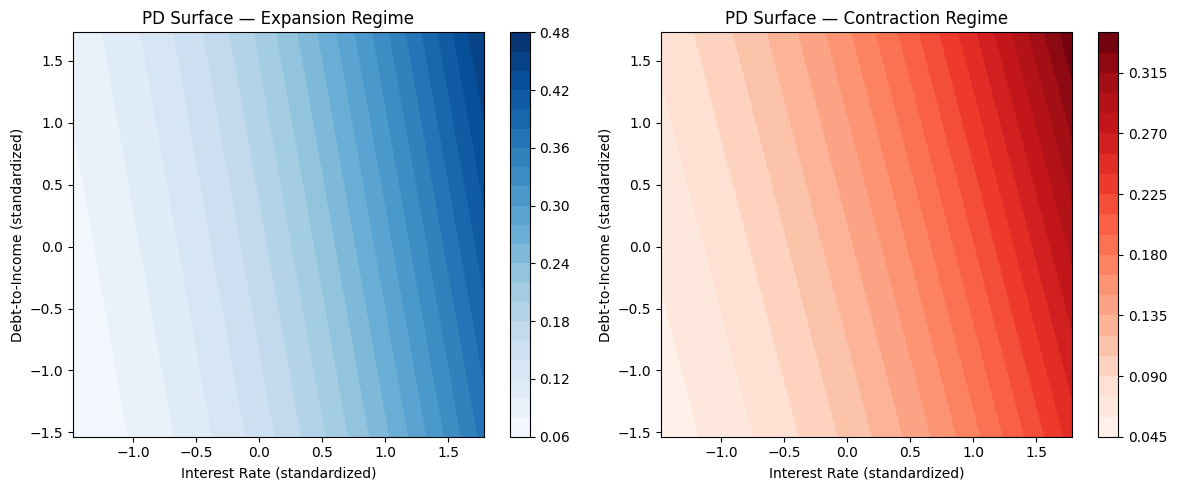

In [46]:
plt.figure(figsize=(12, 5))

# Expansion
plt.subplot(1, 2, 1)
c1 = plt.contourf(R, D, pd_expansion, levels=20, cmap='Blues')
plt.colorbar(c1)
plt.title('PD Surface — Expansion Regime')
plt.xlabel('Interest Rate (standardized)')
plt.ylabel('Debt-to-Income (standardized)')

# Contraction
plt.subplot(1, 2, 2)
c2 = plt.contourf(R, D, pd_contraction, levels=20, cmap='Reds')
plt.colorbar(c2)
plt.title('PD Surface — Contraction Regime')
plt.xlabel('Interest Rate (standardized)')
plt.ylabel('Debt-to-Income (standardized)')

plt.tight_layout()
plt.show()


In [71]:
import os
os.makedirs('data/processed', exist_ok=True)


In [72]:
df_regime.to_parquet(
    'data/processed/df_regime.parquet',
    engine='fastparquet'
)
